<h1><center>Data handling with Pandas</center></h1>

<h2>Analysis 1</h2>

** Tag sessions per users when the time difference between any consecutive pair of events is below 1 hour.**

**1 - Import the necessary packages and libaries**

In [1]:
import pandas as pd #data structures and analysis tool
import matplotlib.pyplot as plt #for visualisation 
import seaborn as sns #for visualisation 
%matplotlib inline 

**2 - Data import and cleaning **

In [2]:
# read and save the csv in a dataframe called 'learner'
learner = pd.read_csv('learner_item_data.csv') 

In [3]:
#to display the 5 first rows of the csv file
learner.head() 

,uuid,created_at,trainer_item_id
0,6953977,2017-01-16 10:54:43.386,0
1,6953977,2017-01-16 10:56:25.717,1
2,6953977,2017-01-16 10:55:50.642,2
3,6953977,2017-01-16 10:54:19.796,3
4,6953977,2017-01-16 10:55:10.654,1


In [4]:
learner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144310 entries, 0 to 1144309
Data columns (total 3 columns):
uuid               1144310 non-null int64
created_at         1144310 non-null object
trainer_item_id    1144310 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.2+ MB


I am now checking if the dataset has any duplicates. Based on the information provided, I assume that a user cannot have replied to the same question multiple times, at the same exact day and time. We are noticing  **171** duplicate values that I decide to delete from the dataset.

In [5]:
learner = learner.drop_duplicates()
learner.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1144139 entries, 0 to 1144309
Data columns (total 3 columns):
uuid               1144139 non-null int64
created_at         1144139 non-null object
trainer_item_id    1144139 non-null int64
dtypes: int64(2), object(1)
memory usage: 34.9+ MB


**4 - Get the time difference between pair of events**

The idea here is to create new columns to ease the table's manipulation and allow us to reach the final dataset format requested in the PDF. The first very important step is to sort the values by user id and time, in order to be certain that the times are consecutive ones and by user! 

Knowing that they are consecutive I am then able to calculate the time difference with the .shift() method allowing to subtract the time in row n with the one in row n-1.

In [6]:
#sort the values by user id and time
learner_sorted = learner.sort_values(['uuid','created_at']) 

In [7]:
#change the data type of the "created_at" column from object to datetime for the .shift() method to work
learner_sorted['created_at'] = pd.to_datetime(learner_sorted['created_at']) 

In [8]:
#create a column with the previous id based on row n
learner_sorted['previousid'] = learner_sorted['uuid'].shift()

#apply the time difference in a new column named 'delta' only if the previous id is the same than the id at the row n (meaning: only if it's the same user!)
learner_sorted = learner_sorted.assign(delta = (learner_sorted['created_at'] - learner_sorted['created_at'].shift()).where(learner_sorted['uuid'] == learner_sorted['previousid'], 0))

#create a column 'deltatime' that saves the info collected in 'delta' but just with the hours, minutes and seconds
learner_sorted['deltatime'] = pd.to_datetime(learner_sorted['delta']).dt.strftime('%H:%M:%S')

In [9]:
#create a column 'date' that saves the day when an event occured
learner_sorted['date'] = learner_sorted['created_at'].dt.date

#create a column 'deltadays' that saves the day difference from a event to another
learner_sorted['deltadays'] = learner_sorted['delta'].dt.days

In [10]:
#create a column 'time' by first extracting it from 'created_at' then shape it in the desire format with the .dt.strftime() method
learner_sorted['time'] = learner_sorted['created_at'].dt.time
learner_sorted['time'] = pd.to_datetime(learner_sorted['created_at']).dt.strftime('%H:%M')

Now that we have the time difference in 'deltatime' and the days' difference (if any) in 'deltadays', we now can uniform their units of time to minutes.

This is important because the end goal is to create a new session per user if the time difference from a session to another is higher than 60 minutes!

After converting the values, I am then creating a new column that holds the sum of 'deltatime' and 'deltadays'.

In [11]:

def time_convert(x):#to convert the time '%H:%M:%S' into minutes
    h,m,s = map(int,x.split(':'))
    return (h*60+m+(s/60))

def days_convert(x):#to convert the days into minutes
    d = x
    return d*1440

learner_sorted['deltatimeminutes'] = learner_sorted['deltatime'].iloc[1:].apply(time_convert) #holds the delta time in minutes
learner_sorted['deltadaysminutes'] = learner_sorted['deltadays'].iloc[1:].apply(days_convert) #holds the delta time in additional days

In [12]:
#sum up 'deltatimeminutes' and 'deltadaysminutes' to have the total minutes difference from an event to another
learner_sorted['totaldeltaminutes'] = learner_sorted['deltatimeminutes']+learner_sorted['deltadaysminutes'] 

In [13]:
#check the first rows of the new 'learner_sorted' dataframe
learner_sorted.head() 

,uuid,created_at,trainer_item_id,previousid,delta,deltatime,date,deltadays,time,deltatimeminutes,deltadaysminutes,totaldeltaminutes
689933,2990,2016-12-25 11:27:22.905,2,NaN,0 days 00:00:00,00:00:00,2016-12-25,0,11:27,NaN,NaN,NaN
689927,2990,2016-12-25 11:27:28.985,0,2990.0,0 days 00:00:06.080000,00:00:06,2016-12-25,0,11:27,0.100000,0.0,0.100000
689931,2990,2016-12-25 11:27:33.603,3,2990.0,0 days 00:00:04.618000,00:00:04,2016-12-25,0,11:27,0.066667,0.0,0.066667
689929,2990,2016-12-25 11:27:38.010,1,2990.0,0 days 00:00:04.407000,00:00:04,2016-12-25,0,11:27,0.066667,0.0,0.066667
689544,2990,2016-12-28 09:40:57.271,604,2990.0,2 days 22:13:19.261000,22:13:19,2016-12-28,2,09:40,1333.316667,2880.0,4213.316667


Here is the data frame at this stage, for example here we know that the user 2990 created a new session on the 26th of December 2016 because the time difference with the previous event equals 4213.316667 minutes which is higher than 60 minutes! The next step is to write some code to tag those sessions for us!

**5 - Encode the sessions of each user**

To tag the sessions I am using the 'previousid' variable to be able to distinguish if we are tagging a new user or not. 
This is important because I am using here the GroupBy.cumcount() method that counts each item in each group in our case starting from 1.

But there are conditions that need to be met for the count to start from 1 again:
- the minutes' difference need to be higher than 60, or 
- the id from row n-1 is different from the one from n (meaning that we are dealing with different users)

The second point is to start the count when we have a change of customer id.

In [14]:
#create the conditions for the counting to start
cond = (learner_sorted['totaldeltaminutes'] > 60) | (learner_sorted['previousid'] != learner_sorted['uuid'])

#creating a new column 'sessions' to save the results when the conditons above are applied
learner_sorted['sessions'] = learner_sorted[cond].groupby(['uuid']).cumcount()+1

#print the head of the dataframe
learner_sorted.head()

,uuid,created_at,trainer_item_id,previousid,delta,deltatime,date,deltadays,time,deltatimeminutes,deltadaysminutes,totaldeltaminutes,sessions
689933,2990,2016-12-25 11:27:22.905,2,NaN,0 days 00:00:00,00:00:00,2016-12-25,0,11:27,NaN,NaN,NaN,1.0
689927,2990,2016-12-25 11:27:28.985,0,2990.0,0 days 00:00:06.080000,00:00:06,2016-12-25,0,11:27,0.100000,0.0,0.100000,NaN
689931,2990,2016-12-25 11:27:33.603,3,2990.0,0 days 00:00:04.618000,00:00:04,2016-12-25,0,11:27,0.066667,0.0,0.066667,NaN
689929,2990,2016-12-25 11:27:38.010,1,2990.0,0 days 00:00:04.407000,00:00:04,2016-12-25,0,11:27,0.066667,0.0,0.066667,NaN
689544,2990,2016-12-28 09:40:57.271,604,2990.0,2 days 22:13:19.261000,22:13:19,2016-12-28,2,09:40,1333.316667,2880.0,4213.316667,2.0


Now we can see that the count starts from 1 when we have a new id and when the time difference is higher than 60 minutes. However, when the following time difference is below 60 for the same user, no conditions are met so null values are returned. 

To solve this problem we can use the fill.na() method that fills up the missing value with the previous non-missing ones. This is perfect in our case because the missing values and the first non-missing one above are from the same session (same user id and a time difference below 60 minutes).

The last thing is to calculate the sessions' lengths in order to answer the next question. To do so, I am creating a column 'sessionlength', this column is ignoring the 'totaldeltaminutes' from the first event of each session.

In [15]:
#fill the missing values with the previous non missing one
learner_sorted['sessions'].fillna(method = 'ffill', inplace = True)

In [16]:
#create a column'sessionlength' that will allow us to sum the length of a session
learner_sorted = learner_sorted.assign(sessionlength = (learner_sorted['totaldeltaminutes']).where(learner_sorted['sessions'] - learner_sorted['sessions'].shift() == 0, 0))

Now that we have all the columns needed we can filter them and grab the ones requested in the PDF: user id, the sessions, and the time in the '%H:%M' format.

In [17]:
#select needed columns and set index for grouping by sessions and user id
final_df = learner_sorted[['uuid','time','sessions']].set_index(['sessions','uuid'])
final_df.head()

time
sessions uuid       
1.0      2990  11:27
         2990  11:27
         2990  11:27
         2990  11:27
2.0      2990  09:40

<h2>Analysis 2</h2>

**1 - What is the distribution of session lengths?**

We know that the maximum length of a session is 481.43 minutes which is about 8 hours, but on a global scale how are the lengths distributed? 

I am first grabbing the variables needed, then group them by user id and sessions, to sum up the minutes spent on each event.

In [18]:
distlengths = learner_sorted[['uuid','sessions','sessionlength']]
distlengths = distlengths.groupby(['uuid','sessions']).sum()
distlengths['sessionlength'].max()

481.43333333333362

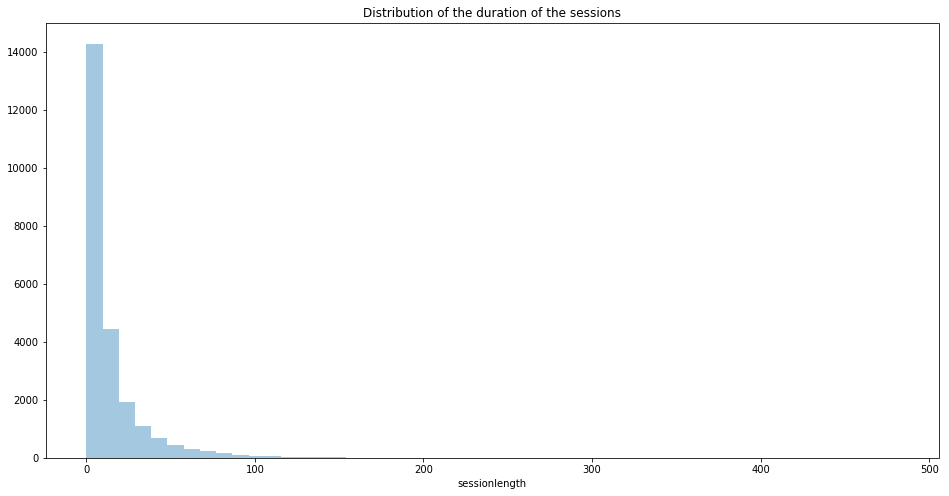

In [19]:
plt.figure(figsize = (16,8))
sns.distplot(distlengths['sessionlength'],kde=False ).set_title('Distribution of the duration of the sessions');

The graph below is a closer look by limiting the axis to 50 minutes. As we can see most of the data has a session length up to 10 minutes, the second bin represents the length between 10 and 20 minutes which represents about 4000 sessions.

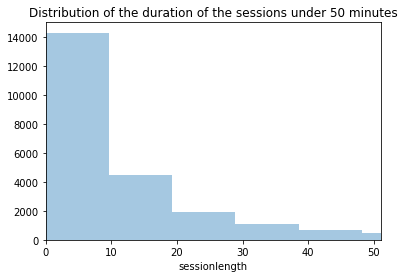

In [20]:
g = sns.distplot(distlengths['sessionlength'],kde=False)
g.set(xlim = (0,51))
g.set_title('Distribution of the duration of the sessions under 50 minutes');

**Having a better picture of the session's duration distribution let's check the distribution of the sessions. For example, how many times the session number 3 appears?**

To answer this question we need to grab the column 'sessions' from the previous data frame and then can use Seaborn's distplot function to plot its distribution.

Because the data frame has a row by user id, session, date and time we can decide to drop the duplicate rows in order to only keep the session number by user.

In [21]:
distsessions = learner_sorted[['uuid','sessions']]
distsessions = distsessions.drop_duplicates()

In [22]:
distsessions.head()

,uuid,sessions
689933,2990,1.0
689544,2990,2.0
690562,2990,3.0
689543,2990,4.0
689723,2990,5.0


As we can see from the first plot, the data is also right-skewed, the most common number of session per user is 1 and the number of users decreases gradually with the number of sessions increasing.

With the graph below I am having a closer look, filtering the number of sessions that are less than 40 (where most of the data is concentrated).

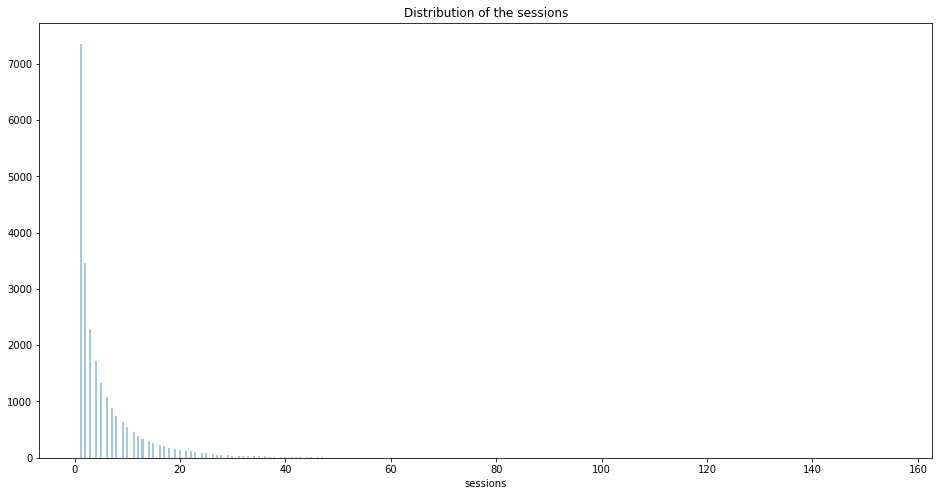

In [23]:
plt.figure(figsize = (16,8))
g= sns.distplot(distsessions['sessions'], norm_hist = False, kde = False, bins ='auto')
g.set_title('Distribution of the sessions');

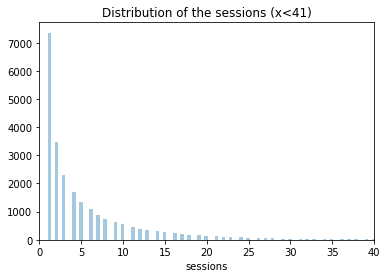

In [24]:
g = sns.distplot(distsessions['sessions'], norm_hist = False, kde = False, bins ='auto')
g.set(xlim = (0,40))
g.set_title('Distribution of the sessions (x<41)');

**2 - How many people do several sessions a day?**

Let's now create another sample of the learner_sorted dataset by grabbing the columns we need and group the rows by id and date by calculating the sum of unique session's number.

For example, because the user id 2990 had 3 different sessions on the 01 of January 2017, by applying what I explaining above we are ending up with the number of unique values for this session's column, meaning 3.

In [25]:
#grab the columns we need
sessionsday = learner_sorted[['uuid','date','sessions']]

#group by 'uuid', 'date' and calculate the sum of unique session's number 
sessionsday = pd.DataFrame(sessionsday.groupby(['uuid', 'date'])['sessions'].nunique())

#display the head of the dataframe
sessionsday.head()

sessions
uuid date                
2990 2016-12-25         1
     2016-12-28         1
     2016-12-31         1
     2017-01-01         3
     2017-01-02         1

At this stage what's left is to ignore the days where the user had only one session, and drop the rows where missing values are returned because those rows are not meeting the condition: 'sessionsday[sessionsday > 1]'

In [26]:
#set the filter condition
sessionsday = sessionsday[sessionsday > 1]

#drop the missing values
sessionsday.dropna(inplace = True)

sessionsday.head()

sessions
uuid  date                
2990  2017-01-01       3.0
      2017-02-01       2.0
12409 2017-01-13       2.0
39446 2017-01-08       2.0
49901 2017-01-14       2.0

Comparing the two tables above we can clearly see that the sessions equaling 1 have been removed. To finish, we just need to count the number of unique user id from this latest table.

In [27]:
#reset index to be able to do some calculation on "uuid'
sessionsday = sessionsday.reset_index()

#calculate the count of unique user ids
sessionsday['uuid'].nunique()

863

In [28]:
#calculate the difference 
learner_sorted['uuid'].nunique() - sessionsday['uuid'].nunique()

6492

**863** people do several sessions a day, the other 6492 have done only one session per day.

**2 - How many sessions?**

My logic here is to first calculate the average sessions per day and per user. From this, I decided to group the mean with the sum of users. For example, we have 754 people who have done in average 2 sessions a day and only 2 have done 4 sessions a day.

In [29]:
#save a new dataframe with the average sessions by user
sessionsmany = pd.DataFrame(sessionsday[['uuid','sessions']].groupby('uuid')['sessions'].mean()).reset_index()

#by session sum up the number of users
sessionsmany = pd.DataFrame(sessionsmany.groupby('sessions')['uuid'].count()).reset_index()

sessionsmany

,sessions,uuid
0,2.000000,754
1,2.076923,1
2,2.166667,4
3,2.181818,1
4,2.200000,3
5,2.222222,1
6,2.250000,9
7,2.285714,2
8,2.333333,14
9,2.400000,3


Let's plot this, but to facilitate the reading of it I decided to bin the sessions.

In [30]:
#create the bins
bins = [1,2.5,3,3.5,4]

#create a new column 'sessionbinned' with the corresponding bin for each row
sessionsmany['sessionbinned'] = pd.cut(sessionsmany['sessions'], bins)

#group by bins
sessionsmany = sessionsmany.groupby('sessionbinned').sum().reset_index()

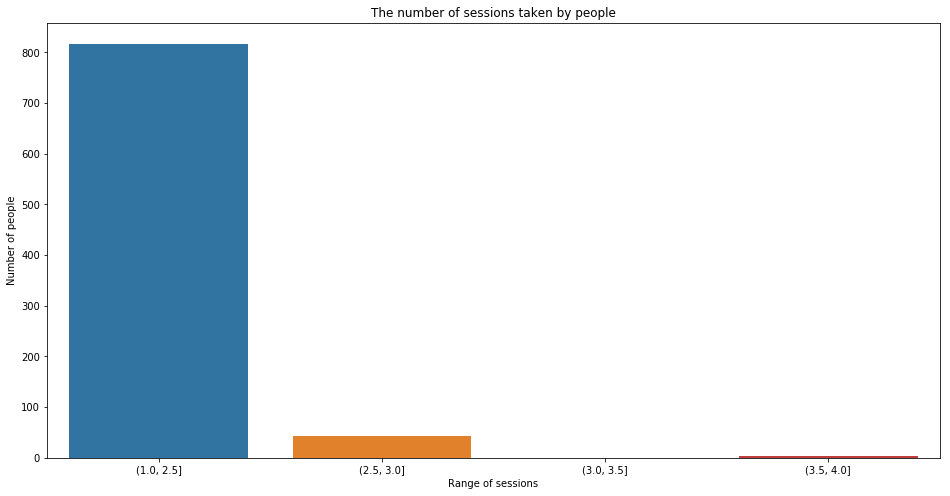

In [31]:
plt.figure(figsize = (16,8))
g = sns.barplot(x ='sessionbinned', y = 'uuid', data = sessionsmany)
g.set_title('The number of sessions taken by people')
g.set(ylabel = 'Number of people', xlabel = 'Range of sessions');

From the users doing more than one session per day most of them do between 2 and 2.5 sessions per day. 


Thank you for reading.**

*Bamby Gassama*